<font color=green>
    
# Dogs vs Cats </font>

구글 드라이브 문서에 있는 dogs-vs-cats.zip을 다운받으셔서 압축을 풀고 진행하시면 됩니다.  
이번 과제의 목표는 배웠던 CNN Architecture를 적용시켜보는 것입니다. 

   **< 목차 >**
1. Setting
 - 1) Import libraries
 - 2) Hyperparameters
2. Data
 - 1) Get Images
 - 2) Use DataLoader
 - 3) Check Images
3. Modeling
4. Loss Function & Optimizer
5. Train
 - 1) Train
 - 2) Test

## 1. Settings

#### 1) Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
''' 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using PyTorch version: {torch.__version__}, Device: {device}')
BATCH_SIZE = 8
EPOCHS = 10

Using PyTorch version: 1.8.1, Device: cuda


#### 2) Hyperparamters

In [3]:
mean = (0.450, 0.455, 0.457)
std = (0.195, 0.195, 0.195)

batch_size = 8
learning_rate = 0.003
epochs = 10
image_size = 196

# data augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std = std)
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


## 2. Data

#### 1) Get Images

In [4]:
# dir 각자 데이터 압축푼 폴더에 맞게 수정

train_dir = '../cat_dog_images/train'
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)

valid_dir = '../cat_dog_images/valid'
valid_data = datasets.ImageFolder(root=valid_dir, transform=test_transforms)

test_dir = '../cat_dog_images/test'
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

#### 2) Use DataLoader

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)
    # drop_last 처리로 해줘야 하는 이유: 마지막에 배치에 안맞게 데이터 몇개 남을시 forward에서 view이후 size_mismatch오류가 일어남
print(f'train images: {len(train_loader.dataset)}')
print(f'valid images: {len(valid_loader.dataset)}')
print(f'test images: {len(test_loader.dataset)}')

train images: 20000
valid images: 2500
test images: 2500


#### 3) Check Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


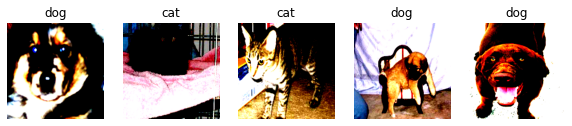

In [6]:
np.random.seed(42)
random_nums = [np.random.randint(1, 20001) for i in range(5)]

plt.figure(figsize=(10, 2))
for i in range(len(random_nums)):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(train_loader.dataset[random_nums[i]][0], (1,2,0)))
    plt.title(f'{"cat" if train_loader.dataset[random_nums[i]][1] == 0 else "dog"}')
    plt.axis('off')

## 3. Modeling

In [7]:
# activation function
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [8]:
'''모델설계'''
'''이번에 배운 3가지의 Architecture들을 활용하여 가능한 좋은 성능을 내보세요.'''
# nn.Module을 상속받는 CNN 클래스로 모델 작성(클래스명 바꾸어도 되고 밑에 똑같이 수정만 하면 됨.)
# 모델링 자유: 단순히 conv, relu, pooling만 번갈아하면 점수 안나옴. 2주차에 배운 것들 활용하면 금방 점수 개선됨.

drop_prob = 0.3           # drop_prob는 hyper parameter이므로 미리 설정한다.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            #nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        
        self.fc1 = nn.Linear(4*4*1024, 1024, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.layer7 = nn.Sequential(
            self.fc1,
            nn.BatchNorm1d(1024),
            Mish(),
            nn.Dropout(p = drop_prob)
        )
        
        self.fc2 = nn.Linear(1024, 2, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        
        self.layer8 = nn.Sequential(
            self.fc2,
            nn.LogSoftmax(dim=1)
        )
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer7(out)
        out = self.layer8(out)
        return out

In [9]:
''' 모델설계 '''
class VGG(nn.Module):
    def __init__(self, features, num_classes=2, init_weights=True):
        super(VGG, self).__init__()        
        self.features = features #convolution        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            Mish(),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            Mish(),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)   #Convolution 
        x = x.view(x.size(0), -1) #
        x = self.classifier(x) #FC layer
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # Conv2d layer 가중치 초기화
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1) # BatchNorm Normalization 가중치 초기화 
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01) # FC layer 가중치 초기화  
                nn.init.constant_(m.bias, 0)

In [10]:
# VGG 16 네트워크의 Out_channel 수 
# 사용자가 custom 가능 
cfg = [16,16,'M',16,16,'M',32,32,'M',64,64,'M',128,128,128,'M'] #13 + 3 = vgg16

In [11]:
# architecture가 발전할수록 층이 점점 많아짐 => 기존처럼 layer마다 층을 쌓는건 비효율적
# 이 방법은 cfg라는 output_channel의 집합인 리스트를 만들어서 반복문으로 접근하여 layer를 쌓음
# M일 경우 Maxpooling을 진행하고 그렇지 않은 경우에는 Conv2d층을 추가함 (만일 batch_norm=True일 경우 BN을 추가)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), Mish()] # layers에 conv2d와 BN와 Mish를 차례대로 추가
            else:
                layers += [conv2d, Mish()] # layers에 conv2d와 Relu만 추가 
            in_channels = v
                     
    return nn.Sequential(*layers)

In [12]:
make_layers(cfg, batch_norm=True)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Mish()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Mish()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Mish()
  (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Mish()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

In [13]:
CNN_vgg = VGG(make_layers(cfg, batch_norm=True), num_classes=2, init_weights=True)

## 4. Loss_funtion & Optimizer

In [14]:
import gc 
gc.collect()
torch.cuda.empty_cache()

In [15]:
model = CNN_vgg.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Mish()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Mish()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Mish()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

## 5. Train

#### **1) Train**

In [16]:
gc.collect()
torch.cuda.empty_cache()

In [17]:
train_loss_arr = []
valid_loss_arr = []

for epoch in range(epochs):
    start = time.time()
    train_avg_loss = 0
    model.train()
    for image, label in train_loader:
        # ------- assign train data
        image = image.to(device)
        label = label.to(device)
        # ------- forward prop
        optimizer.zero_grad()
        output = model(image)
        # ------- backward prop
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        # ------- get train performance
        train_avg_loss += loss / len(train_loader)
    train_loss_arr.append(train_avg_loss)
    print(f'Epoch : {epoch+1}/{epochs}, train_loss : {train_avg_loss:.4f}', end=' / ')
     
    model.eval()
    with torch.no_grad():
        valid_acc=0
        valid_avg_loss=0
        for image, label in valid_loader:
            # ------- assign valid data
            image = image.to(device)
            label = label.to(device)
            # ------- forward prop
            val_output = model(image)
            val_loss = criterion(val_output,label)
            # ------- get valid performance
            val_batch_acc = ((val_output.argmax(dim=1) == label).float().mean()) # acc = 맞춘 개수 / 배치사이즈
            valid_acc += (val_batch_acc / len(valid_loader)).float().item() # acc / total_Iteration 
            valid_avg_loss += (val_loss / len(valid_loader)).float().item() # val_loss / total_Iteration
        valid_loss_arr.append(valid_avg_loss) 
        print(f'val_loss : {valid_avg_loss:.4f}, valid_acc : {valid_acc:.4f}, takes {time.time() - start}secs')

<ipython-input-7-c00e0ecebc6a>:10: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


Epoch : 1/10, train_loss : 0.7035 / val_loss : 0.6798, valid_acc : 0.6983, takes 443.3826034069061secs
Epoch : 2/10, train_loss : 0.6248 / val_loss : 0.5377, valid_acc : 0.7300, takes 444.41772174835205secs
Epoch : 3/10, train_loss : 0.5826 / val_loss : 0.5262, valid_acc : 0.7264, takes 445.60160994529724secs
Epoch : 4/10, train_loss : 0.5278 / val_loss : 0.4610, valid_acc : 0.7813, takes 446.70391821861267secs
Epoch : 5/10, train_loss : 0.4897 / val_loss : 0.4292, valid_acc : 0.8197, takes 444.0359740257263secs
Epoch : 6/10, train_loss : 0.4367 / val_loss : 0.3504, valid_acc : 0.8349, takes 445.62250804901123secs
Epoch : 7/10, train_loss : 0.3913 / val_loss : 0.3648, valid_acc : 0.8486, takes 446.91257214546204secs
Epoch : 8/10, train_loss : 0.3507 / val_loss : 0.2655, valid_acc : 0.8882, takes 448.1468861103058secs
Epoch : 9/10, train_loss : 0.3202 / val_loss : 0.2717, valid_acc : 0.8870, takes 449.60059690475464secs
Epoch : 10/10, train_loss : 0.2981 / val_loss : 0.2410, valid_acc :

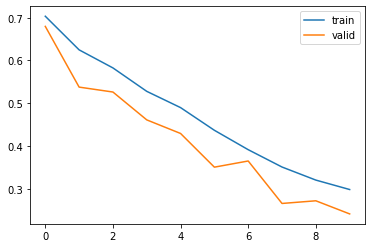

In [18]:
plt.plot(train_loss_arr, label='train')
plt.plot(valid_loss_arr, label='valid')
plt.legend()
plt.show()

#### **2) Test**

In [19]:
with torch.no_grad():
    start = time.time()
    test_acc=0
    model.eval()
    for image, label in test_loader:
        # ------- assign valid data
        image = image.to(device)
        label = label.to(device)
        # ------- forward prop
        test_output = model(image)
        # ------- get valid performance
        test_batch_acc = ((test_output.argmax(dim=1) == label).float().mean()) # acc = 맞춘 개수 / 배치사이즈
        test_acc += test_batch_acc / len(test_loader) # acc / total_Iteration 
    print(f'test_acc : {test_acc:.4f}, takes {time.time() - start}secs')

test_acc : 0.9171, takes 19.7033212184906secs


In [20]:
# CNN() - layer4 - 0.9187 
# CNN() - layer5 - 0.9483
# CNN() - layer6 - 0.9371, 0.9300
# CNN_vgg - 0.9171

**Fin** ────────────────────────────────────────────────────────────────────────────────────────────────